# Assignment 1: Data Curation

In [1]:
import json, requests

import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1) Data Acquistion
---

Data acquisition procedure follows this [tutorial](http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb). The steps include:
* Determine endpoint URL to query data: there are legacy and pageview versions
* Determine the parameters for each legacy API and pageview API. The pageview API includes more fields like `'agent'`
* Query the legacy API from **December 2017 to July 2016**
* Query the pageview API from **June 2015 to September 2018** (no October, 2018 yet)
* Store to 5 .json source files split by pageview and pagecount and view channels

In [2]:
# Similar to tutorial
def api_call(endpoint, parameters, headers):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pv = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

headers = {
    'User-Agent': 'https://github.com/lmtoan',
    'From': 'toanlm@uw.edu'
}

In [3]:
# Import pagecounts
legacy_params = {
    'project' : 'en.wikipedia.org', 
    'access-site' : 'desktop-site',
    'granularity' : 'monthly',
    'start' : '2007120100',
    'end' : '2016080100'
}

# Query pagecount data and store to .json by format
for access in ('desktop-site', 'mobile-site'):
    legacy_params['access-site'] = access
    pc_data = api_call(endpoint_legacy, legacy_params, headers)
    with open('pagecounts_%s_%s-%s.json' %(access, legacy_params['start'][:-4], legacy_params['end'][:-4]), 'w') as f:
        json.dump(pc_data, f)

In [4]:
# Import pageviews
pv_params = {
    'project' : 'en.wikipedia.org',
    'access' : 'desktop',
    'agent' : 'user',
    'granularity' : 'monthly',
    'start' : '2015070100',
    'end' : '2018100100'
}

# Query pageview data and store to .json by format
for access in ('desktop', 'mobile-app', 'mobile-web'):
    pv_params['access'] = access
    pv_data = api_call(endpoint_pv, pv_params, headers)
    with open('data/pageviews_%s_%s-%s.json' %(access, pv_params['start'][:-4], pv_params['end'][:-4]), 'w') as f:
        json.dump(pv_data, f)

2) Data Processing
---

Processing includes these steps:
* Given all the 5 .json source files, read in and concatenate them as Pandas dataframe
* Combine all mobile accesses both view/legacy API to `'mobile'` and refine desktop access to `'desktop'`
* Extract `year` and `month` based on string slicing of `timestamp`
* Groupby counts/pageviews for all mobile/desktop channels

In [5]:
import glob

# Extract all json paths using glob package
paths = glob.glob('data/*.json')

# Concatenate all dataframes to master_df
df_collection = []
for json_path in paths:
    with open(json_path) as j:
        data = json.load(j)
    df = pd.DataFrame(data['items'])
    df['json_path'] = json_path
    df_collection.append(df)
master_df = pd.concat(df_collection)
master_df.reset_index(inplace=True, drop=True) # Reset index after concatenation

In [6]:
# Sanity check
master_df[master_df.timestamp.str.contains('201511')]

,access,access-site,agent,count,granularity,json_path,project,timestamp,views
95,NaN,desktop-site,NaN,5.296956e+09,monthly,data/pagecounts_desktop-site_200712-201608.json,en.wikipedia,2015110100,NaN
108,desktop,NaN,user,NaN,monthly,data/pageviews_desktop_201507-201810.json,en.wikipedia,2015110100,4.287720e+09
147,mobile-app,NaN,user,NaN,monthly,data/pageviews_mobile-app_201507-201810.json,en.wikipedia,2015110100,9.435392e+07
195,NaN,mobile-site,NaN,3.218235e+09,monthly,data/pagecounts_mobile-site_200712-201608.json,en.wikipedia,2015110100,NaN
208,mobile-web,NaN,user,NaN,monthly,data/pageviews_mobile-web_201507-201810.json,en.wikipedia,2015110100,3.142247e+09


In [7]:
data_df = master_df.copy()

# Combine all access
data_df.loc[data_df['access'].isnull(), 'access'] = data_df['access-site']
data_df.loc[data_df.access.str.contains('desktop'), 'access'] = 'desktop'
data_df.loc[data_df.access.str.contains('mobile'), 'access'] = 'mobile'

# Generate year and month
data_df['year'] = data_df.loc[:, 'timestamp'].apply(lambda x: x[:4])
data_df['month'] = data_df.loc[:, 'timestamp'].apply(lambda x: x[4:6])

# Drop unnecessary columns
data_df.drop(['agent', 'granularity', 'json_path', 'project', 'access-site', 'timestamp'], axis=1, inplace=True)

# Fill NaN with zeros
data_df.fillna(0, inplace=True)

# Sanity check
data_df[(data_df['year'] == '2015') & (data_df['month'] == '11')]

,access,count,views,year,month
95,desktop,5.296956e+09,0.000000e+00,2015,11
108,desktop,0.000000e+00,4.287720e+09,2015,11
147,mobile,0.000000e+00,9.435392e+07,2015,11
195,mobile,3.218235e+09,0.000000e+00,2015,11
208,mobile,0.000000e+00,3.142247e+09,2015,11


Flatten the dataframe to create the `pagecount_desktop_views`, `pageview_desktop_views`, `pagecount_mobile_view`, `pageview_mobile_views` as required.

In [8]:
# Create desktop/mobile_views columns
flat_df = data_df.groupby(['access', 'year', 'month'])[['count', 'views']].sum().reset_index()

def create_columns(row):
    if row['access'] == 'desktop':
        row.loc['pagecount_desktop_views'] = row['count']
        row.loc['pageview_desktop_views'] = row['views']
    else:
        row.loc['pagecount_mobile_views'] = row['count']
        row.loc['pageview_mobile_views'] = row['views']
    return row
    
flat_df['pagecount_desktop_views'] = 0
flat_df['pageview_desktop_views'] = 0
flat_df['pagecount_mobile_views'] = 0
flat_df['pageview_mobile_views'] = 0

flat_df = flat_df.apply(lambda r: create_columns(r), axis=1)
flat_df.drop(['count', 'views'], axis=1, inplace=True)
flat_df = flat_df.groupby(['year', 'month']).sum().reset_index()

# Sanity check
flat_df[(flat_df['year'] == '2016') & (flat_df['month'] == '07')]

,year,month,pagecount_desktop_views,pageview_desktop_views,pagecount_mobile_views,pageview_mobile_views
103,2016,07,5.363966e+09,4.337866e+09,3.500661e+09,3.496574e+09


Sum the `desktop` and `mobile` channels to create `all_views` columns

In [9]:
# Sum views/counts to create all_views columns
flat_df['pagecount_all_views'] = flat_df['pagecount_desktop_views'] + flat_df['pagecount_mobile_views']
flat_df['pageview_all_views'] = flat_df['pageview_desktop_views'] + flat_df['pageview_mobile_views']

# Sanity check
flat_df[(flat_df['year'] == '2016') & (flat_df['month'] == '07')]

# Sanity Check: 2016/7
# 8.864628e+09	5.363966e+09	3.500661e+09	7.834440e+09	4.337866e+09	3.496574e+09

,year,month,pagecount_desktop_views,pageview_desktop_views,pagecount_mobile_views,pageview_mobile_views,pagecount_all_views,pageview_all_views
103,2016,07,5.363966e+09,4.337866e+09,3.500661e+09,3.496574e+09,8.864628e+09,7.834440e+09


Save to .csv as required.

In [10]:
# Save to .csv
flat_df.to_csv('en-wikipedia_traffic_200712-201809.csv')

3) Analysis
---

To generate the plot below, the steps are:
* Add a pseudo-date and generate a `date` column with format `YYYY-MM-DD`
* Change 0 back to NaN so as not to plot those points
* Divide all the pagecount and pageview by $10^6$ to label as millions
* Plot, label, and save figure as necessary

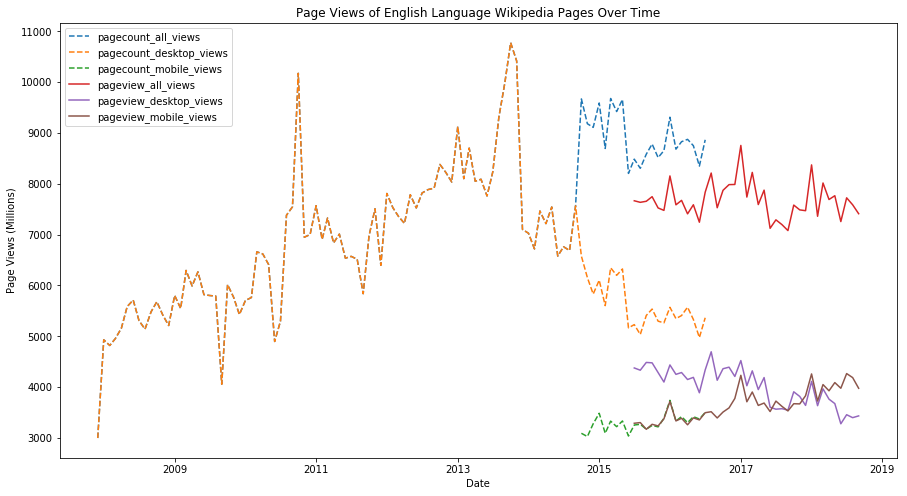

In [16]:
# Create column 'date' and add pseudo date of 01 in the format 'YYYY-MM-DD'
flat_df['date'] = flat_df['year'] + '-' + flat_df['month'] + '-01'
flat_df['date'] = pd.to_datetime(flat_df['date'], format ='%Y-%m-%d')
flat_df.replace(0, float('nan'), inplace=True)

# Plot all available columns
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(flat_df['date'], flat_df['pagecount_all_views']/1e6, '--')
ax.plot(flat_df['date'], flat_df['pagecount_desktop_views']/1e6, '--')
ax.plot(flat_df['date'], flat_df['pagecount_mobile_views']/1e6, '--')
ax.plot(flat_df['date'], flat_df['pageview_all_views']/1e6)
ax.plot(flat_df['date'], flat_df['pageview_desktop_views']/1e6)
ax.plot(flat_df['date'], flat_df['pageview_mobile_views']/1e6)

# Set legends, labels
ax.legend(loc='upper left')
ax.set_xlabel('Date')  
ax.set_ylabel('Page Views (Millions)')  
ax.set_title('Page Views of English Language Wikipedia Pages Over Time')

# Save figure to .png
fig.savefig('ts_plot.png')

README editor

In [17]:
%%file README.md
# Assignment 1: Data Curation

* Project Goal

![](figs/ts_plot.png)

* List the license of the source data and a link to the Wikimedia Foundation REST API terms of use: https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions
* Link to all relevant API documentation
* Describe the values of all fields in your final data file.

| Column                  | Value     | Description                                                                                                               |
|-------------------------|-----------|---------------------------------------------------------------------------------------------------------------------------|
| year                    | YYYY      | Year of access                                                                                                            |
| month                   | MM        | Month of access                                                                                                           |
| pagecount_all_views     | num_views | Aggregate of pagecount of all channels, given month-year between Jan 2008 to July 2016                                    |
| pagecount_desktop_views | num_views | Aggregate of pagecount of desktop channel, given month-year between Jan 2008 to July 2016                                 |
| pagecount_mobile_views  | num_views | Aggregate of pagecount of mobile channel, given month-year between Jan 2008 to July 2016                                  |
| pageview_all_views      | num_views | Aggregate of pageview of all channels, given month-year between July 2015 to October 2018                                 |
| pageview_desktop_views  | num_views | Aggregate of pageview of desktop channel, given month-year between July 2015 to October 2018                              |
| pageview_mobile_views   | num_views | Aggregate of pageview of mobile channels (mobile app and mobile site), given month-year between July 2015 to October 2018 |

* List any known issues or special considerations with the data that would be useful for another researcher to know. For example, you should describe that data from the Pageview API excludes spiders/crawlers, while data from the Pagecounts API does not.

Overwriting README.md
